# Bayesian Logistic Regression on the Kaggle titanic dataset

Initial implementation from https://blog.ceshine.net/post/pymc3_first/

In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

# PyMC3
import pymc3 as pm

# Pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler

# Machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

## Load data

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')


In [3]:
# fill missing embarkation port

class FillPort(TransformerMixin):
    def fit(self, X, y=None):
        self.most_common_port=X.Embarked.dropna().mode()[0]
        return self
    def transform(self, X):
        X["Embarked"].fillna(self.most_common_port,inplace=True)
        return X



In [4]:
# fill missing fare - only one in the test set... really not well thought function

class FillFare(TransformerMixin):
    def fit(self, X, y=None):
        self.fare=11.00205
        return self
    def transform(self, X):
        X["Fare"].fillna(self.fare,inplace=True)
        return X

#print(test_df.loc[test_df["Fare"].isnull()])

#Calculate fare for the missing fare in the test set

#temp1=test_df.loc[test_df["Pclass"]==3]
#temp2=temp1.loc[temp1["Embarked"]=="S"]
#temp3=temp2.loc[temp2["Age"]>40]
#print(temp3.median())



In [5]:
# change Pclass

class ChangePclass(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        tag=pd.get_dummies(X["Pclass"],prefix="Pclass")
        X=pd.concat([X,tag], axis=1)
        return X.drop("Pclass", axis=1)


In [6]:
# change embarked

class ChangeEmbarked(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        tag=pd.get_dummies(X["Embarked"],prefix="Embarked")
        X=pd.concat([X,tag], axis=1)
        return X.drop("Embarked", axis=1)
        



In [7]:
# change sex from string to numeric

class ChangeSex(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X["Gender"]=X["Sex"].map({"male":1,"female":0})
        return X.drop("Sex", axis=1)

In [8]:
# change name

class ChangeName(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X["Title"]=X["Name"].map(lambda name:name.split(',')[1].split('.')[0].strip())
        Title_Dictionary = {
            "Capt":       "Crew",
            "Col":        "Crew",
            "Major":      "Crew",
            "Jonkheer":   "Rare",
            "Don":        "Rare",
            "Sir" :       "Rare",
            "Dr":         "Crew",
            "Rev":        "Crew",
            "the Countess":"Rare",
            "Dona":       "Rare",
            "Mme":        "Mrs",
            "Mlle":       "Miss",
            "Ms":         "Mrs",
            "Mr" :        "Mr",
            "Mrs" :       "Mrs",
            "Miss" :      "Miss",
            "Master" :    "Master",
            "Lady" :      "Rare"
        }
        X["Title"]=X.Title.map(Title_Dictionary)
        tag=pd.get_dummies(X["Title"],prefix="Title")
        X=pd.concat([X,tag], axis=1)
        return X.drop("Name", axis=1).drop("Title", axis=1)
        
    


In [9]:
# change ticket

class ChangeTicket(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):

        # a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
        def cleanTicket(ticket):
            ticket = ticket.replace('.','')
            ticket = ticket.replace('/','')
            ticket = ticket.split()
            ticket = list(ticket)
            ticket = map(lambda t : t.strip() , ticket)
            ticket = list(ticket)
            ticket = filter(lambda t : not t.isdigit(), ticket)
            ticket = list(ticket)
            if len(ticket) > 0:
                return ticket[0]
            else: 
                return 'XXX'
        
        X["Ticket"]=X["Ticket"].map(cleanTicket)
        tag=pd.get_dummies(X["Ticket"],prefix="Ticket")
        X=pd.concat([X,tag], axis=1)
        return X.drop("Ticket",axis=1)
        

    

In [10]:
# change cabin

class ChangeCabin(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X["Cabin"].fillna("U", inplace=True)
        X["Cabin"]=X["Cabin"].map(lambda c : c[0])
        tag=pd.get_dummies(X["Cabin"], prefix="Cabin")
        X=pd.concat([X,tag], axis=1)
        return X.drop("Cabin", axis=1)
        




In [11]:
# create family parameters

class CreateFamily(TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X["FamilySize"]=X["SibSp"]+X["Parch"]+1
        X["Alone"]=X["FamilySize"].map(lambda s : 1 if s == 1 else 0)
        X["NormalFamily"]=X["FamilySize"].map(lambda s : 1 if 2<=s<=4 else 0)
        X["LargeFamily"]=X["FamilySize"].map(lambda s : 1 if 5<=s else 0)
        return X
 

In [12]:
# fill missing Age with Regressor (must be last - regressor needs numeric attribs)

class ChangeAge(BaseEstimator, TransformerMixin):
    def __init__(self):
        #self.model = LinearRegression()
        self.model = RandomForestRegressor() 
        #self.model = KNeighborsRegressor(n_neighbors=3) 
    def fit(self, X, y=None):
        self.X_withage=X.loc[X["Age"].notnull()]
        y=self.X_withage["Age"]
        X_clear=self.X_withage.drop("Age", axis=1)
        if "Survived" in X_clear.columns:
            X_clear=X_clear.drop("Survived", axis=1)
        self.model.fit(X_clear, y)
        #acc=(cross_val_score(self.model, X_clear, y, cv=5, scoring="accuracy").mean()) * 100
        #print(acc)
        return self
    def transform(self, X):
        X_to_replace=X.drop("Age", axis=1)
        X_to_replace_clear=X_to_replace
        if "Survived" in X_to_replace_clear.columns:
            X_to_replace_clear=X_to_replace_clear.drop("Survived", axis=1)
        y_to_replace=pd.DataFrame(self.model.predict(X_to_replace_clear))
        y_to_replace.columns=["Age"]
        X_to_replace["Age"]=X[:]["Age"].fillna(y_to_replace[:]["Age"]) #is there a way to write this clearly?
        return X_to_replace
        

In [13]:
feature_engineering_pipeline = Pipeline([
    ('fill_port', FillPort()),
    ('fill_fare', FillFare()),
    ('change_embarked', ChangeEmbarked()),
    ('change_pclass', ChangePclass()),
    ('change_sex', ChangeSex()),
    ('change_name', ChangeName()),
    ('change_ticket', ChangeTicket()),
    ('change_cabin', ChangeCabin()),
    ('create_family', CreateFamily()),
    ('change_age', ChangeAge()),
])



In [14]:
train_df_tr=pd.DataFrame(feature_engineering_pipeline.fit_transform(train_df))
test_df_tr=pd.DataFrame(feature_engineering_pipeline.fit_transform(test_df))

In [15]:
combined=pd.concat([train_df.drop("Survived",axis=1), test_df], axis=0)
combined_tr=pd.DataFrame(feature_engineering_pipeline.fit_transform(combined))

In [16]:
X_train = combined_tr[0:891]
X_test = combined_tr[891:]
Y_train = train_df_tr["Survived"]

In [17]:
#feature scaling

scaler=StandardScaler()

X_train[['Fare', 'Age']]=scaler.fit_transform(X_train[['Fare', 'Age']])
X_test[['Fare', 'Age']]=scaler.fit_transform(X_test[['Fare', 'Age']])


C:\ProgramData\Anaconda3\envs\theano\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\ProgramData\Anaconda3\envs\theano\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\envs\theano\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

## Prepare the training data

In [18]:
y = Y_train

In [19]:
x = X_train
x.loc[:, "Bias"] = 1
x=x.drop('PassengerId', axis=1)

C:\ProgramData\Anaconda3\envs\theano\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\envs\theano\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [20]:
non_useful_features=[]
# features identified in the model below. When applying Beta prior, the posterior were "visually" like uniforms
for i in [15,16,19,20,21,22,24,25,26,27,28,29,31,32,33,34,35,36,37,38,39,41,43,45,46,47,48,49,56,57,58,59,60]:
    non_useful_features.append (x.columns[i])
    
features = [c for c in x.columns if c not in non_useful_features]

x=x[features]
x.describe()

,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Gender,...,Cabin_A,Cabin_B,Cabin_C,Cabin_U,FamilySize,Alone,NormalFamily,LargeFamily,Age,Bias
count,891.000000,891.000000,8.910000e+02,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,8.910000e+02,891.0
mean,0.523008,0.381594,3.987333e-18,0.188552,0.086420,0.725028,0.242424,0.206510,0.551066,0.647587,...,0.016835,0.052750,0.066218,0.771044,1.904602,0.602694,0.327722,0.069585,7.974666e-18,1.0
std,1.102743,0.806057,1.000562e+00,0.391372,0.281141,0.446751,0.428790,0.405028,0.497665,0.477990,...,0.128725,0.223659,0.248802,0.420397,1.613459,0.489615,0.469646,0.254589,1.000562e+00,0.0
min,0.000000,0.000000,-6.484217e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-2.135665e+00,1.0
25%,0.000000,0.000000,-4.891482e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-6.409009e-01,1.0
50%,0.000000,0.000000,-3.573909e-01,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,-7.437205e-02,1.0
75%,1.000000,0.000000,-2.424635e-02,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,1.000000,0.000000,5.920257e-01,1.0
max,8.000000,6.000000,9.667167e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,11.000000,1.000000,1.000000,1.000000,3.644381e+00,1.0


In [21]:
x.columns

Index(['SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Gender', 'Title_Crew',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Ticket_A4',
       'Ticket_A5', 'Ticket_CA', 'Ticket_PC', 'Ticket_SOC', 'Ticket_SOPP',
       'Ticket_SOTONOQ', 'Ticket_WC', 'Ticket_WEP', 'Ticket_XXX', 'Cabin_A',
       'Cabin_B', 'Cabin_C', 'Cabin_U', 'FamilySize', 'Alone', 'NormalFamily',
       'LargeFamily', 'Age', 'Bias'],
      dtype='object')

## Build the model

In [38]:
logistic_model = pm.Model()

with logistic_model:
    # let' use non-informative priors
    theta = pm.Normal('theta', 0, sd=100, shape=(1, x.shape[1]))
    #theta = pm.Beta('theta', 1,1, shape=(1,x.shape[1]))
    
    # Logistic regression
    p = pm.invlogit(pm.math.sum(theta*x, axis=1))
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=p, observed=y)

In [39]:
with logistic_model:
    # move the chain to the MAP which should be a good starting point
    #start = pm.find_MAP()
    #step = pm.Metropolis()
    #step = pm.NUTS(scaling=start,max_treedepth=20)
    #trace = pm.sample(50000, step, start)
    
    mean_field = pm.fit(30000)
    trace=mean_field.sample(10000)

Average Loss = 549.43: 100%|████████████████████████████████████████████████████| 30000/30000 [00:37<00:00, 806.42it/s]
Finished [100%]: Average Loss = 549.46


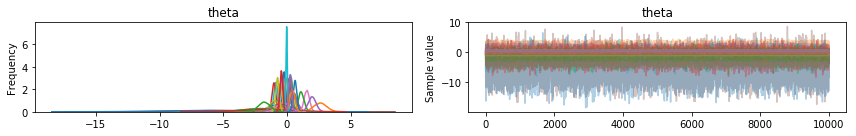

In [25]:
pm.traceplot(trace, ['theta']);

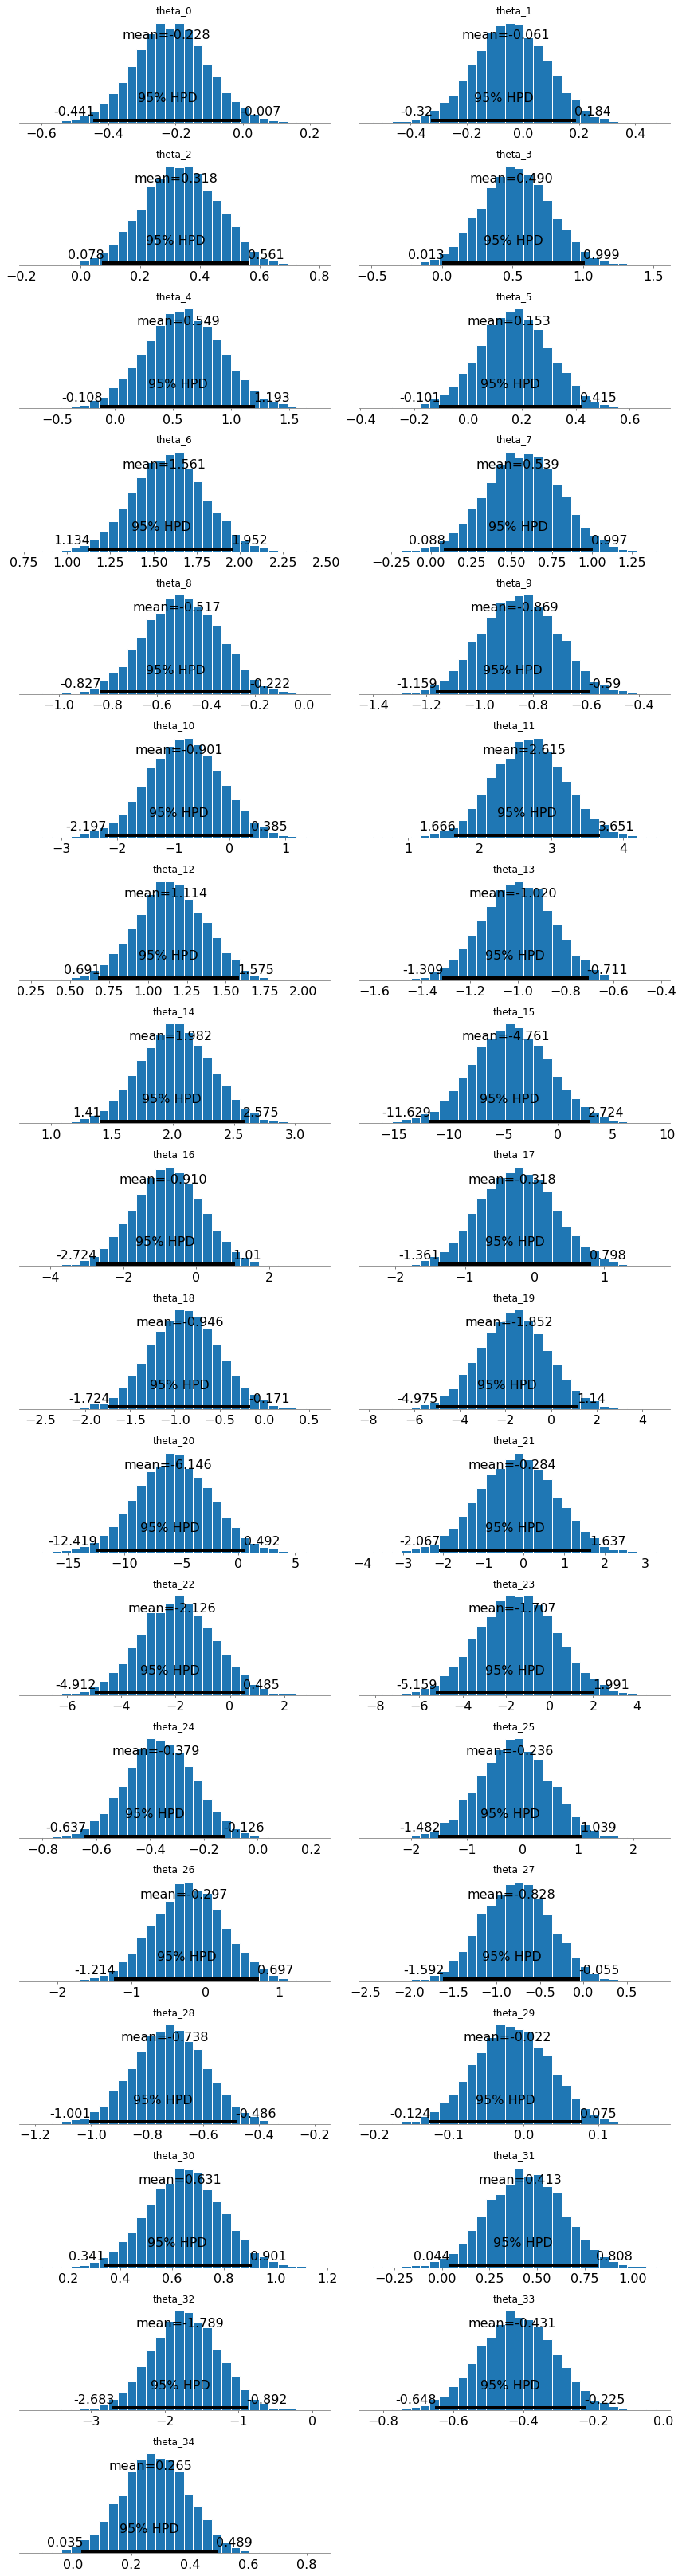

In [26]:
pm.plot_posterior(trace);

## Prepare the testing data

In [27]:
new_x = X_test
new_x.loc[:, "Bias"] = 1
new_x=new_x.drop('PassengerId', axis=1)


C:\ProgramData\Anaconda3\envs\theano\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\envs\theano\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [28]:
new_x=new_x[features]

new_x.shape

(418, 35)

In [29]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

## Take average of all the eta's implied by the samples

In [30]:
trace['theta'].shape

(10000, 1, 35)

In [31]:
eta = np.zeros(new_x.shape[0])
for row in trace['theta']:
    row=row[0]
    eta = np.add(eta, np.dot(new_x, row.transpose()))
eta = np.divide(eta, trace['theta'].shape[0])

In [32]:
p = invlogit(eta)
p[:20]

array([  8.35552403e-02,   5.53608326e-01,   1.00629591e-01,
         7.23984080e-02,   7.20404122e-01,   1.05315220e-01,
         6.78627156e-01,   1.30408595e-01,   8.73317429e-01,
         6.26599451e-04,   1.41211625e-01,   2.75166645e-01,
         9.80486363e-01,   4.77960475e-02,   8.82068477e-01,
         9.44092837e-01,   2.09439995e-01,   1.15698346e-01,
         5.88659158e-01,   7.47220100e-01])

## Prepare Submission

In [33]:
prediction = pd.DataFrame({'Survived_p':p})

In [34]:
prediction["PassengerId"] = test_df["PassengerId"]
prediction['Survived'] = (prediction['Survived_p']>0.5) * 1

In [35]:
prediction.drop('Survived_p', 1).to_csv('output.csv', index=False)

In [36]:
prediction['Sex'] = train_df["Sex"]

In [ ]:
prediction

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

test_df_y = pd.read_csv('test_y.csv')
test_df_y_tr=pd.DataFrame(feature_engineering_pipeline.fit_transform(test_df_y))

#confusion_matrix(test_df_y_tr['Survived'], prediction['Survived'])
#accuracy_score(test_df_y_tr['Survived'], prediction['Survived'])